## Get Sentinel 2 Data on CDSE using ODATA and Boto3

In [ ]:
import sys
import os
import pandas as pd
import os
from loguru import logger
import time
import rasterio
import os
import io
import cv2
import numpy as np
from PIL import Image

from dotenv import load_dotenv
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Now import the module
from src.auth.auth import S3Connector
from src.utils.utils import remove_last_segment_rsplit
from src.utils.cdse_utils import (create_cdse_query_url, download_bands)

In [ ]:
def create_cdse_query_url(
    collection_name="SENTINEL-2",
    product_type="MSIL2A",
    polygon=None,
    start_interval=None,
    end_interval=None,
    max_cloud_cover=100,
    max_items=1000,
    additional_filters=None,
    orderby="ContentDate/Start"  # Add orderby parameter with default value
):
    """
    Create a query URL for the Copernicus Data Space Ecosystem OData API.

    Parameters:
    -----------
    collection_name : str
        The collection name (e.g., 'SENTINEL-2', 'SENTINEL-1')
    product_type : str
        The product type (e.g., 'MSIL2A', 'MSIL1C', 'GRD')
    polygon : str
        WKT polygon string for spatial filtering
    start_interval : str
        Start time in ISO format with Z for UTC (e.g., '2023-01-01T00:00:00.000Z')
    end_interval : str
        End time in ISO format with Z for UTC (e.g., '2023-01-31T23:59:59.999Z')
    max_cloud_cover : int
        Maximum cloud cover percentage (0-100)
    max_items : int
        Maximum number of items to return
    additional_filters : list
        List of additional filter strings to add to the query
    orderby : str or None
        Field to order results by (e.g., 'ContentDate/Start', 'ContentDate/Start desc')
        Set to None to skip ordering

    Returns:
    --------
    str
        Complete URL for the OData API query
    """

    # Basic filter for collection
    filter_parts = [f"Collection/Name eq '{collection_name}'"]

    # Add spatial filter if provided
    if polygon:
        filter_parts.append(f"OData.CSC.Intersects(area=geography'SRID=4326;{polygon}')")

    # Add product type filter
    if product_type:
        filter_parts.append(f"contains(Name,'{product_type}')")

    # Add temporal filters if provided
    if start_interval:
        filter_parts.append(f"ContentDate/Start gt {start_interval}")
    if end_interval:
        filter_parts.append(f"ContentDate/Start lt {end_interval}")

    # Add cloud cover filter if applicable
    # Only add for optical sensors (Sentinel-2)
    if collection_name == 'SENTINEL-2' and max_cloud_cover < 100:
        filter_parts.append(
            f"Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and "
            f"att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
        )

    # Add any additional filters
    if additional_filters:
        filter_parts.extend(additional_filters)

    # Construct the URL with all filters
    filter_string = " and ".join(filter_parts)
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter={filter_string}"

    # Add orderby parameter if specified
    if orderby:
        url += f"&$orderby={orderby}"

    # Add top parameter for limiting results
    url += f"&$top={max_items}"

    url += "&$expand=Attributes"

    return url

In [ ]:
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

# Now import the module
from src.auth.auth import S3Connector
from src.utils.utils import extract_s3_path_from_url


load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"
DATASET_VERSION = "V3"
BUCKET_NAME = "eodata"
BASE_DIR = f"/mnt/disk/dataset/sentinel-ai-processor"
DATASET_DIR = f"{BASE_DIR}/{DATASET_VERSION}"
BANDS = ['TCI']

connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
bucket = s3.Bucket(BUCKET_NAME)

In [ ]:
import pandas as pd

df_l1c = pd.read_csv("/mnt/disk/dataset/sentinel-ai-processor/V2/test/input.csv")
df_l2a = pd.read_csv("/mnt/disk/dataset/sentinel-ai-processor/V2/test/target.csv")
df_l1c = df_l1c[75:76]
df_l2a = df_l2a[75:76]

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import os
from typing import Optional

def parse_safe_manifest(content: str) -> Optional[pd.DataFrame]:
    """
    Parse a Sentinel SAFE manifest file and extract href attributes.

    Args:
        manifest_path (str): Path to the manifest.safe file

    Returns:
        pd.DataFrame: DataFrame containing href values and file information,
                     or None if an error occurred
    """
    try:

        # Parse the content
        root = ET.fromstring(content)

        # Extract all elements with an href attribute using a generic approach
        hrefs = []
        for elem in root.findall(".//*[@href]"):
            href = elem.get('href')
            if href:
                hrefs.append(href)

        # Create DataFrame with href values and file information
        df_files = pd.DataFrame({
            'href': hrefs,
            'file_type': [href.split('.')[-1] if '.' in href else 'unknown' for href in hrefs],
            'file_name': [os.path.basename(href) for href in hrefs]
        })


        return df_files

    except ET.ParseError as e:
        logger.error(f"XML parsing error : {str(e)}")
        return None
    except Exception as e:
        logger.error(f"Error processing manifest: {str(e)}")
        return None


def download_manifest(s3_client, bucket_name, s3_path, max_attempts=5, retry_delay=2):
    """
    Download and parse a Sentinel-2 product manifest file from S3.

    Args:
        s3_client: Boto3 S3 client
        bucket_name (str): S3 bucket name
        s3_path (str): Base S3 path to the product
        max_attempts (int): Maximum number of download attempts
        retry_delay (int): Seconds to wait between retry attempts

    Returns:
        tuple: (success (bool), dataframe of files or None)
    """
    # Extract base S3 URL and create manifest URL
    s3_base_url = extract_s3_path_from_url(s3_path).replace("/eodata", "")
    s3_manifest_url = f"{s3_base_url}/manifest.safe"

    # Try to download manifest file with retry logic
    attempt = 0
    content = None

    while attempt < max_attempts:
        try:
            # Get the manifest file
            response = s3_client.get_object(Bucket=bucket_name, Key=s3_manifest_url)

            # Check if successful
            if response["ResponseMetadata"]['HTTPStatusCode'] == 200:
                content = response['Body'].read()
                logger.info(f"Downloaded manifest from {s3_manifest_url}")
                break
            else:
                logger.warning(f"Unexpected status: {response['ResponseMetadata']['HTTPStatusCode']}")
                attempt += 1
                time.sleep(retry_delay)

        except Exception as e:
            logger.warning(f"Error downloading manifest: {str(e)}")
            attempt += 1
            time.sleep(retry_delay)

    if content is None:
        logger.error(f"Failed to download manifest after {max_attempts} attempts")
        return False, None

    # Parse the manifest into a dataframe
    df_files = parse_safe_manifest(content=content)

    return df_files


def filter_band_files(df_files, bands=None, product_type=None, resolution=None):
    """
    Filter a dataframe for Sentinel-2 band files supporting both L1C and L2A formats.

    Args:
        df_files (pd.DataFrame): DataFrame with 'href' column containing file paths
        bands (list, optional): List of band names to filter for (e.g., ['B02', 'B03', 'B04']).
                               If None, defaults to RGB bands.
        product_type (str, optional): Product type ('L1C' or 'L2A'). If None, both types are included.
        resolution (str or int, optional): Specific resolution to filter for L2A products ('10m', '20m', '60m' or 10, 20, 60).
                                         If None, includes all resolutions.

    Returns:
        pd.DataFrame: Filtered DataFrame containing only requested band files
    """
    # Define default bands to filter if not specified
    if bands is None:
        bands = ['B02', 'B03', 'B04']  # RGB bands by default

    # Convert resolution to string if it's an integer
    if resolution is not None:
        resolution = str(resolution)

    # Build regex patterns to match both L1C and L2A formats
    band_patterns = []

    for band in bands:
        # L1C format: IMG_DATA/*_B02.jp2
        if product_type is None or product_type.upper() == 'L1C':
            band_patterns.append(r'IMG_DATA/.*_' + band + r'\.jp2')

        # L2A formats with correct pattern: IMG_DATA/R20m/T55KGR_20200103T001101_B02_20m.jp2
        if product_type is None or product_type.upper() == 'L2A':
            if resolution:
                # If specific resolution is provided, filter for that resolution
                band_patterns.append(r'IMG_DATA/R' + resolution + r'm/.*_' + band + r'_' + resolution + r'm\.jp2')
            else:
                # If no resolution is specified, include all resolutions
                band_patterns.extend([
                    r'IMG_DATA/R10m/.*_' + band + r'_10m\.jp2',
                    r'IMG_DATA/R20m/.*_' + band + r'_20m\.jp2',
                    r'IMG_DATA/R60m/.*_' + band + r'_60m\.jp2'
                ])

    filter_condition = False
    for pattern in band_patterns:
        filter_condition = filter_condition | df_files['href'].str.contains(pattern, regex=True)

    df_gr = df_files[filter_condition].copy()  # Create a copy to avoid the warning


    # Remove leading ./ from href paths
    df_gr['href'] = df_gr['href'].str.replace(r'^\./', '', regex=True)

    return df_gr


def get_product_content(s3_client, bucket_name, object_url):
    """
    Download the content of a product from S3 bucket.

    Args:
        s3_client: boto3 S3 client object
        bucket_name (str): Name of the S3 bucket
        object_url (str): Path to the object within the bucket

    Returns:
        bytes: Content of the downloaded file
    """
    print(f"Downloading {object_url}")

    try:
        # Download the file from S3
        response = s3_client.get_object(Bucket=bucket_name, Key=object_url)
        content = response['Body'].read()
        print(f"Successfully downloaded {object_url}")
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        raise

    return content


def get_product(s3_client, bucket_name, object_url, output_path,
                           resize=False, target_size=None, interpolation=cv2.INTER_CUBIC,
                           format='JPEG'):
    """
    Retrieve a satellite image from S3, optionally resize it, and save it.

    Parameters:
    -----------
    s3_client : boto3.client
        Initialized S3 client
    bucket_name : str
        S3 bucket name
    object_url : str
        S3 object key/URL for the image
    output_path : str
        Path where the image should be saved
    resize : bool
        Whether to resize the image (default: False)
    target_size : tuple or None
        Target size as (width, height). Required if resize=True.
    interpolation : int
        OpenCV interpolation method (default: cv2.INTER_CUBIC)
    format : str
        Output image format (default: 'JPEG')

    Returns:
    --------
    str : Path to the saved image
    """
    # Get the image content from S3
    product_content = get_product_content(s3_client=s3_client,
                                          bucket_name=bucket_name,
                                          object_url=object_url)

    # Open as PIL Image
    image = Image.open(io.BytesIO(product_content))

    # Only resize if requested
    if resize:
        if target_size is None:
            raise ValueError("target_size must be specified when resize=True")

        # Convert to numpy array
        image_array = np.array(image)

        # Resize using OpenCV
        resized_array = cv2.resize(image_array, target_size, interpolation=interpolation)

        # Convert back to PIL Image
        image = Image.fromarray(resized_array)

    # Save the image (resized or original) to the specified path
    image.save(output_path, format=format)

    return output_path


def download_bands(s3_client, bucket_name, df, bands, product_type, resolution, output_dir, max_attempts=10, retry_delay=10):
    """
    Download Sentinel-2 band files from S3 based on dataframe information.

    Args:
        s3_client: S3 client object
        bucket: S3 bucket object
        bucket_name: Name of the S3 bucket
        df (pd.DataFrame): DataFrame with 'S3Path' column containing S3 paths
        bands (list): List of bands to download
        product_type (str): Product type ('L1C' or 'L2A')
        resolution (int, optional): Resolution in meters. Required for L2A products.
        output_dir (str): Base directory to save files
        max_attempts (int): Maximum number of download attempts
        retry_delay (int): Delay between retry attempts in seconds
    """

    for index, row in df.iterrows():
        # Extract base S3 URL
        s3_base_url = extract_s3_path_from_url(row['S3Path']).replace("/eodata","")
        s3_manifest_url = f"{s3_base_url}/manifest.safe"
        _, filename = os.path.split(s3_manifest_url)

        # Try to download manifest file with retry logic
        attempt = 0
        content = None

        while attempt < max_attempts:
            try:
                # Get the manifest file
                response = s3_client.get_object(Bucket=bucket_name, Key=s3_manifest_url)
                # Check if successful
                if response["ResponseMetadata"]['HTTPStatusCode'] == 200:
                    content = response['Body'].read()
                    logger.info(f"Downloaded manifest from {s3_manifest_url}")
                    break
                else:
                    logger.warning(f"Unexpected status: {response['ResponseMetadata']['HTTPStatusCode']}")
                    attempt += 1
                    time.sleep(retry_delay)

            except Exception as e:
                logger.warning(f"Error downloading manifest: {str(e)}")
                attempt += 1
                time.sleep(retry_delay)

        if content is None:
            logger.error(f"Failed to download manifest after {max_attempts} attempts, skipping this product")
            continue

        df_tmp = parse_safe_manifest(content=content)
        df_bands = filter_band_files(df_tmp, bands=bands, product_type=product_type, resolution=resolution)

        for gr in df_bands['href']:
            # Create full S3 URL for the band file
            band_s3_url = f"{s3_base_url}/{gr}"

            # Extract just the filename from the path
            filename = os.path.basename(gr)

            # Extract product ID for folder structure
            path_safe = s3_base_url.split(os.sep)[7].replace(".SAFE","")
            path_save = os.path.join(output_dir, path_safe)
            os.makedirs(path_save, exist_ok=True)

            # Download the file with retry logic
            attempt = 0

            while attempt < max_attempts:
                try:
                    # Download the band file
                    # bucket.download_file(band_s3_url, f"{path_save}/{filename}")

                    output_path = f"{path_save}/{filename}"
                    get_product(s3_client=s3_client, bucket_name=bucket_name,
                                object_url=band_s3_url, output_path=output_path,
                           resize=False, target_size=(1830, 1830), interpolation=cv2.INTER_CUBIC,
                           format='PNG')
                    logger.info(f"Downloaded {filename} to {path_save}")
                    break
                except Exception as e:
                    logger.warning(f"Error downloading band file {filename}: {str(e)}")
                    attempt += 1
                    if attempt < max_attempts:
                        logger.info(f"Retrying download of {filename}, attempt {attempt+1} of {max_attempts}")
                        time.sleep(retry_delay)
                    else:
                        logger.error(f"Failed to download {filename} after {max_attempts} attempts")


In [ ]:
download_bands(s3_client=s3_client, bucket_name=BUCKET_NAME, df=df_l1c,
                product_type="L1C", bands=BANDS, resolution=None, output_dir="/home/ubuntu/project/sentinel-2-ai-processor/dataset/",
                max_attempts=10, retry_delay=10)

In [ ]:
download_bands(s3_client=s3_client, bucket_name=BUCKET_NAME, df=df_l2a,
                product_type="L2A", bands=BANDS, resolution=10, output_dir="/home/ubuntu/project/sentinel-2-ai-processor/dataset/",
                max_attempts=10, retry_delay=10)

In [ ]:
import matplotlib.pyplot as plt
import cv2

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

path = "/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220106T102319_N0301_R065_T32TPS_20220106T111539/T32TPS_20220106T102319_B02.png"

# Read and resize image
img = cv2.imread(path)
img = cv2.resize(img, (512, 512))

# Create mask where image is NOT zero (non-black pixels)
mask_nonzero = np.any(img != 0, axis=2)

# Apply mask: keep non-zero pixels, set zero pixels to black
masked_img = np.zeros_like(img)
masked_img[mask_nonzero] = img[mask_nonzero]

# Show masked image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
plt.title("Non-Zero Pixels in Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_nonzero, cmap='gray')
plt.title("Mask of Non-Zero Pixels")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
plt.imshow(mask_nonzero)

In [ ]:
img = cv2.imread("/home/ubuntu/project/sentinel-2-ai-processor/dataset/S2A_MSIL1C_20190308T102021_N0500_R065_T32TNT_20221111T224128/T32TNT_20190308T102021_TCI.jp2")
img = cv2.resize(img , (512,512))
plt.imshow(img)

In [ ]:
img = cv2.imread("/home/ubuntu/project/sentinel-2-ai-processor/dataset/S2A_MSIL2A_20190308T102021_N0500_R065_T32TNT_20221123T222853/T32TNT_20190308T102021_TCI_10m.jp2")
img = cv2.resize(img , (512,512))
plt.imshow(img)

In [ ]:
def prepare_paths(path_dir):

    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")

    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output

In [ ]:
version = "V2"

TEST_DIR = f"/mnt/disk/dataset/sentinel-ai-processor/{version}/test/"
df_input, df_output = prepare_paths(TEST_DIR)

In [ ]:
import os
import glob
import cv2
import natsort
import numpy as np
import matplotlib.pyplot as plt

for index in range(len(df_input)):
    print(f"Checking: {df_input['path'][index]}")

    # Load input and output as color (BGR)
    x_paths = natsort.natsorted(glob.glob(os.path.join(df_input['path'][index], "*.png"), recursive=False))
    x_data = cv2.imread(x_paths[0])  # BGR format

    y_paths = natsort.natsorted(glob.glob(os.path.join(df_output['path'][index], "*.png"), recursive=False))
    y_data = cv2.imread(y_paths[0])  # BGR format

    # Create binary masks: 1 where pixel is NOT zero (non-black)
    mask_x = np.any(x_data != 0, axis=2).astype(np.uint8)
    mask_y = np.any(y_data != 0, axis=2).astype(np.uint8)

    # Calculate difference mask
    diff_mask = np.abs(mask_x - mask_y)

    # Count differing pixels
    num_different = np.sum(diff_mask)
    total_pixels = diff_mask.size
    diff_ratio = num_different / total_pixels

    # Check if difference exceeds 10%
    if diff_ratio > 0.10:
        print(f"Difference > 10% at index {index}: {diff_ratio:.2%} different")

        # Overlapping mask
        overlap_mask = np.logical_and(mask_x, mask_y).astype(np.uint8)

        # # Plot masks
        # fig, axs = plt.subplots(1, 4, figsize=(16, 4))

        # axs[0].imshow(mask_x, cmap='gray')
        # axs[0].set_title('Mask X (non-zero pixels)')
        # axs[0].axis('off')

        # axs[1].imshow(mask_y, cmap='gray')
        # axs[1].set_title('Mask Y (non-zero pixels)')
        # axs[1].axis('off')

        # axs[2].imshow(overlap_mask, cmap='gray')
        # axs[2].set_title('Overlap (Both non-zero)')
        # axs[2].axis('off')

        # axs[3].imshow(diff_mask, cmap='hot')
        # axs[3].set_title('Difference Mask')
        # axs[3].axis('off')

        # plt.tight_layout()
        # plt.show()
        # plt.close()


Difference > 10% at index 75: 10025.13% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20190308T102021_N0500_R065_T32TNT_20221111T224128/T32TNT_20190308T102021_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20190308T102021_N0500_R065_T32TNT_20221111T224128/T32TNT_20190308T102021_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20190308T102021_N0500_R065_T32TNT_20221111T224128/T32TNT_20190308T102021_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20190308T102021_N0500_R065_T32TNT_20221123T222853/T32TNT_20190308T102021_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20190308T102021_N0500_R065_T32TNT_20221123T222853/T32TNT_20190308T102021_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20190308T102021_N0500_R065_T32TNT_20221123T222853/T32TNT_20190308T102021_B04_10m.png']


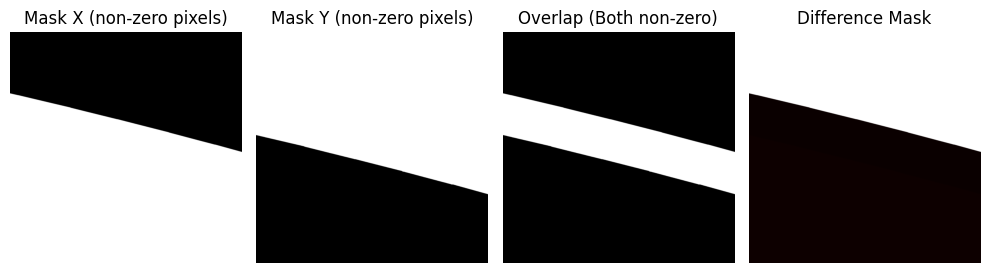

Difference > 10% at index 156: 14103.59% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20200613T103031_N0500_R108_T32UNA_20230614T210728/T32UNA_20200613T103031_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20200613T103031_N0500_R108_T32UNA_20230614T210728/T32UNA_20200613T103031_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20200613T103031_N0500_R108_T32UNA_20230614T210728/T32UNA_20200613T103031_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20200613T103031_N0500_R108_T32UNA_20230416T172456/T32UNA_20200613T103031_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20200613T103031_N0500_R108_T32UNA_20230416T172456/T32UNA_20200613T103031_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20200613T103031_N0500_R108_T32UNA_20230416T172456/T32UNA_20200613T103031_B04_10m.png']


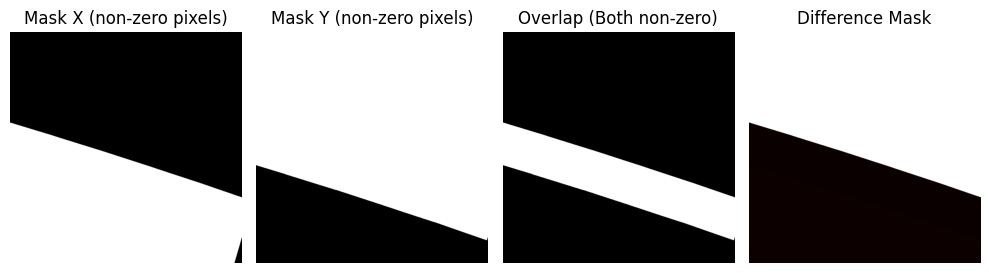

Difference > 10% at index 173: 1972.37% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20200817T102559_N0500_R108_T31TFN_20230423T190131/T31TFN_20200817T102559_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20200817T102559_N0500_R108_T31TFN_20230423T190131/T31TFN_20200817T102559_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20200817T102559_N0500_R108_T31TFN_20230423T190131/T31TFN_20200817T102559_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20200817T102559_N0500_R108_T31TFN_20230420T222228/T31TFN_20200817T102559_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20200817T102559_N0500_R108_T31TFN_20230420T222228/T31TFN_20200817T102559_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20200817T102559_N0500_R108_T31TFN_20230420T222228/T31TFN_20200817T102559_B04_10m.png']


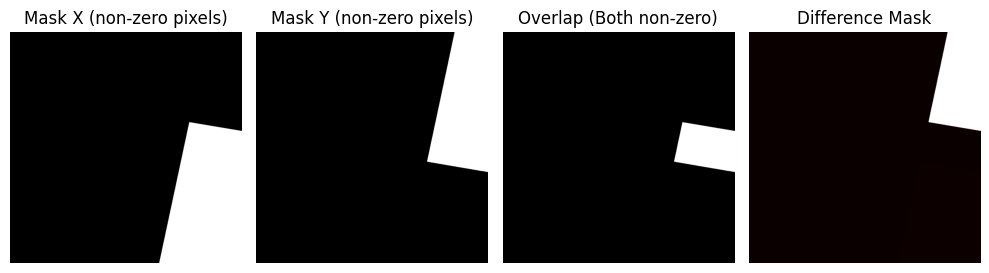

Difference > 10% at index 285: 19.30% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220102T104339_N0301_R008_T31TFN_20220102T113621/T31TFN_20220102T104339_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220102T104339_N0301_R008_T31TFN_20220102T113621/T31TFN_20220102T104339_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220102T104339_N0301_R008_T31TFN_20220102T113621/T31TFN_20220102T104339_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B04_10m.png']


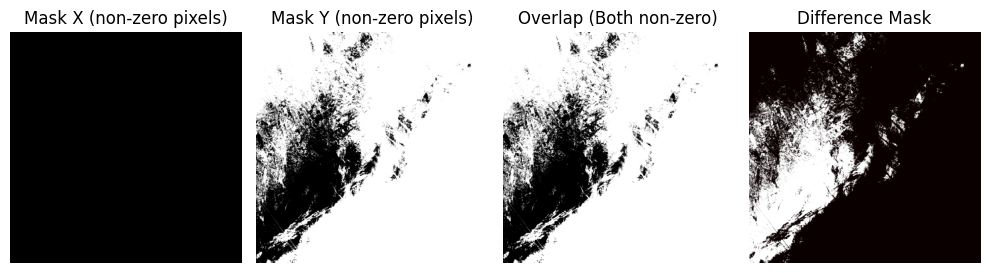

Difference > 10% at index 287: 14.26% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220106T102319_N0301_R065_T32TPS_20220106T111539/T32TPS_20220106T102319_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220106T102319_N0301_R065_T32TPS_20220106T111539/T32TPS_20220106T102319_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20220106T102319_N0301_R065_T32TPS_20220106T111539/T32TPS_20220106T102319_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220106T102319_N0301_R065_T32TPS_20220106T123401/T32TPS_20220106T102319_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220106T102319_N0301_R065_T32TPS_20220106T123401/T32TPS_20220106T102319_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220106T102319_N0301_R065_T32TPS_20220106T123401/T32TPS_20220106T102319_B04_10m.png']


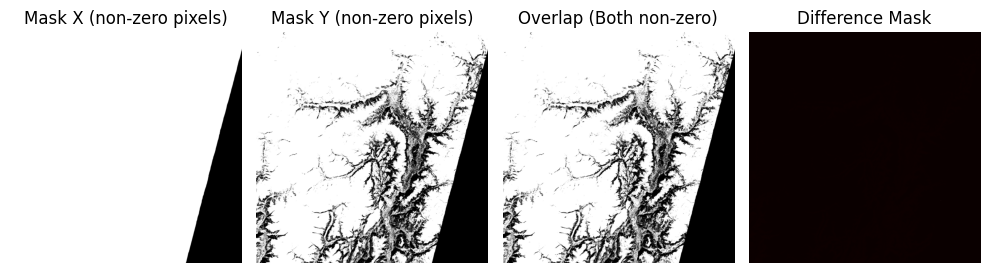

Difference > 10% at index 384: 2424.47% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20221004T103911_N0400_R008_T31UGP_20221004T141105/T31UGP_20221004T103911_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20221004T103911_N0400_R008_T31UGP_20221004T141105/T31UGP_20221004T103911_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2A_MSIL1C_20221004T103911_N0400_R008_T31UGP_20221004T141105/T31UGP_20221004T103911_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20221004T103911_N0400_R008_T31UGP_20221004T182854/T31UGP_20221004T103911_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20221004T103911_N0400_R008_T31UGP_20221004T182854/T31UGP_20221004T103911_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20221004T103911_N0400_R008_T31UGP_20221004T182854/T31UGP_20221004T103911_B04_10m.png']


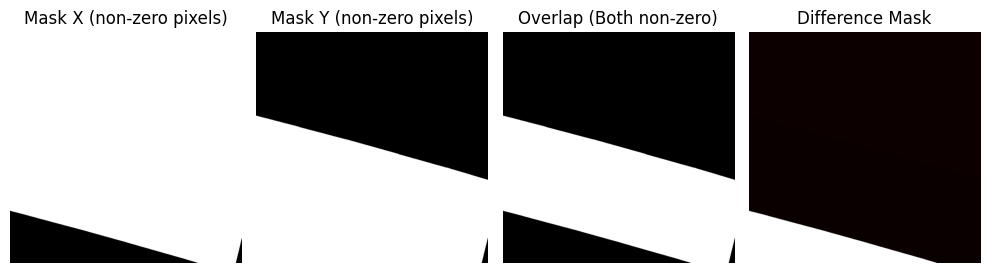

Difference > 10% at index 436: 12.25% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20230331T104629_N0509_R051_T31TEN_20230331T125112/T31TEN_20230331T104629_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20230331T104629_N0509_R051_T31TEN_20230331T125112/T31TEN_20230331T104629_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20230331T104629_N0509_R051_T31TEN_20230331T125112/T31TEN_20230331T104629_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20230331T104629_N0509_R051_T31TEN_20230331T135550/T31TEN_20230331T104629_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20230331T104629_N0509_R051_T31TEN_20230331T135550/T31TEN_20230331T104629_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20230331T104629_N0509_R051_T31TEN_20230331T135550/T31TEN_20230331T104629_B04_10m.png']


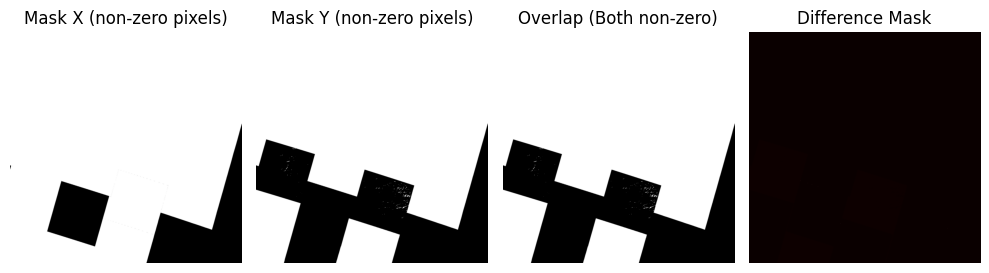

Difference > 10% at index 558: 98.33% different
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20240810T100559_N0511_R022_T32TPS_20240810T124659/T32TPS_20240810T100559_B02.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20240810T100559_N0511_R022_T32TPS_20240810T124659/T32TPS_20240810T100559_B03.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/input/S2B_MSIL1C_20240810T100559_N0511_R022_T32TPS_20240810T124659/T32TPS_20240810T100559_B04.png']
['/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20240810T100559_N0511_R022_T32TPS_20240810T132043/T32TPS_20240810T100559_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20240810T100559_N0511_R022_T32TPS_20240810T132043/T32TPS_20240810T100559_B03_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20240810T100559_N0511_R022_T32TPS_20240810T132043/T32TPS_20240810T100559_B04_10m.png']


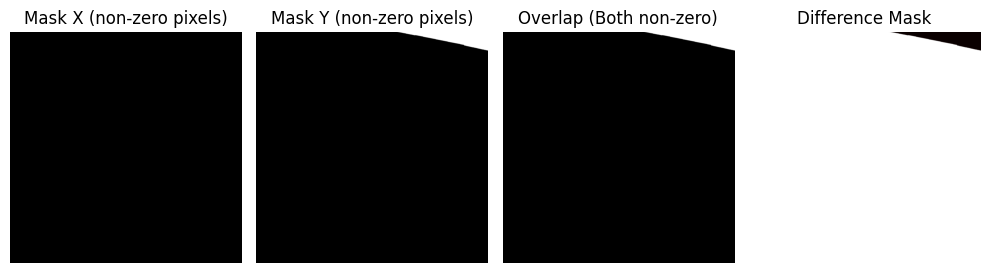

In [71]:
import os
import glob
import cv2
import natsort
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List to store paths where difference > 10%
diff_exceeds_10 = []

for index in range(len(df_input)):
    input_path = df_input['path'][index]
    output_path = df_output['path'][index]
    x_paths = natsort.natsorted(glob.glob(os.path.join(input_path, "*.png"), recursive=False))
    y_paths = natsort.natsorted(glob.glob(os.path.join(output_path, "*.png"), recursive=False))

    x_data = cv2.imread(x_paths[0])
    y_data = cv2.imread(y_paths[0])

    mask_x = np.any(x_data != 0, axis=2).astype(np.uint8)
    mask_y = np.any(y_data != 0, axis=2).astype(np.uint8)

    diff_mask = np.abs(mask_x - mask_y)
    diff_ratio = np.sum(diff_mask) / diff_mask.size

    if diff_ratio > 0.10:
        print(f"Difference > 10% at index {index}: {diff_ratio:.2%} different")
        print(x_paths)
        print(y_paths)
        # Save paths
        diff_exceeds_10.append({
            'input_path': input_path,
            'output_path': output_path,
            'diff_ratio': diff_ratio
        })
        # Optional: Plot masks (same as before)
        overlap_mask = np.logical_and(mask_x, mask_y).astype(np.uint8)
        fig, axs = plt.subplots(1, 4, figsize=(10, 4))

        axs[0].imshow(mask_x, cmap='gray')
        axs[0].set_title('Mask X (non-zero pixels)')
        axs[0].axis('off')

        axs[1].imshow(mask_y, cmap='gray')
        axs[1].set_title('Mask Y (non-zero pixels)')
        axs[1].axis('off')

        axs[2].imshow(overlap_mask, cmap='gray')
        axs[2].set_title('Overlap (Both non-zero)')
        axs[2].axis('off')

        axs[3].imshow(diff_mask, cmap='hot')
        axs[3].set_title('Difference Mask')
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Create DataFrame of mismatched paths
df_diff = pd.DataFrame(diff_exceeds_10)

In [78]:
df_diff['output_path'][1]

'/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2A_MSIL2A_20200613T103031_N0500_R108_T32UNA_20230416T172456'

In [ ]:
data = cv2.imread("/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B03_10m.png")

[ WARN:0@8880.349] global loadsave.cpp:268 findDecoder imread_('/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B02_10m.png', '/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220102T104339_N0301_R008_T31TFN_20220102T122433/T31TFN_20220102T104339_B03_10m.png'): can't open/read file: check file path/integrity


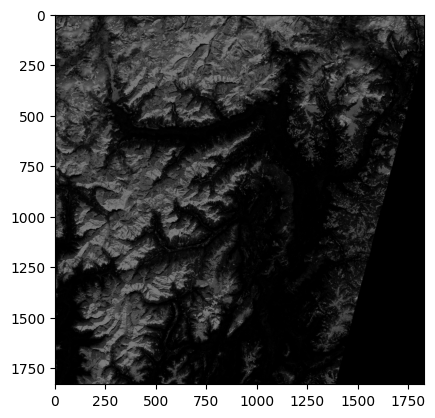

In [85]:
img = cv2.imread("/mnt/disk/dataset/sentinel-ai-processor/V2/test/target/S2B_MSIL2A_20220106T102319_N0301_R065_T32TPS_20220106T123401/T32TPS_20220106T102319_B02_10m.png")
plt.imshow(img)

In [ ]:
mask_x = np.any(img != 0, axis=2).astype(np.uint8)

In [87]:
mask_x = np.any(img != 0, axis=2).astype(np.uint8)
mask_x.shape

(1830, 1830)

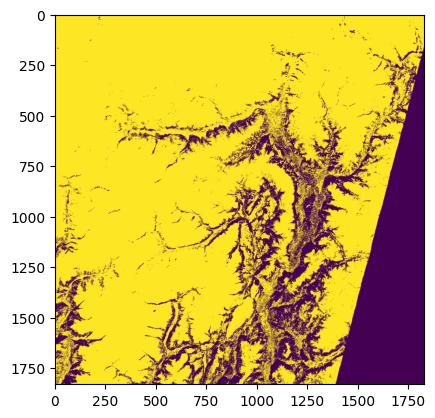

In [88]:
plt.imshow(mask_x)